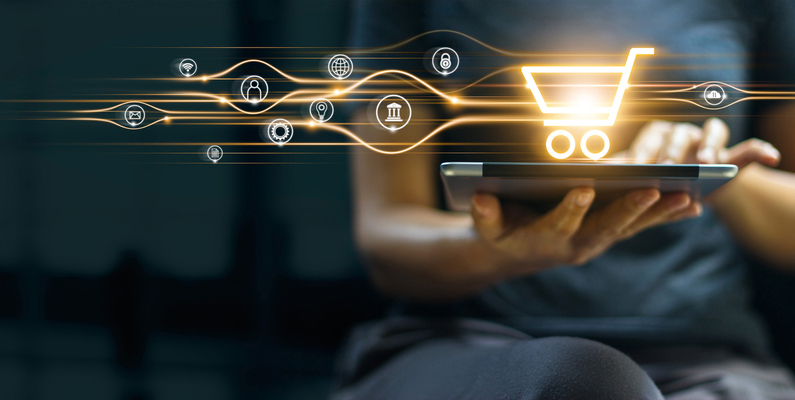

# <center> Online Shoppers Purchasing Intention

На этот раз мы окунёмся в онлайн-маркетинг: будем пытаться предсказать совершение покупки пользователем во время его сессии на сайте некоторого интернет-магазина.

С подробным описанием датасета можно ознакомиться в [источнике](https://www.kaggle.com/datasets/imakash3011/online-shoppers-purchasing-intention-dataset).

In [1]:
# Импортируем необходимые библиотеки
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import metrics # метрики
from sklearn import model_selection # методы разделения и валидации
from sklearn import ensemble # ансамбли

plt.style.use('seaborn-v0_8') # стиль отрисовки seaborn
%matplotlib inline

Прочитаем таблицу с данными и выведем её на экран, чтобы убедиться, что чтение прошло успешно.

In [2]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.zip')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Посмотрим на размер таблицы:

In [3]:
shoppers_data.shape

(12330, 18)

В нашей таблице содержится информация о более чем 12 тысячах сессий на сайте интернет-магазина. Каждая сессия описывается 18 признаками.

Заранее удостоверимся в отсутствии пропусков:

In [4]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Ни в одном из столбцов пропусков нет.

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя функцию get_dummies():

In [5]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Теперь, когда необходимые преобразования выполнены, мы можем говорить о построении модели.

Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


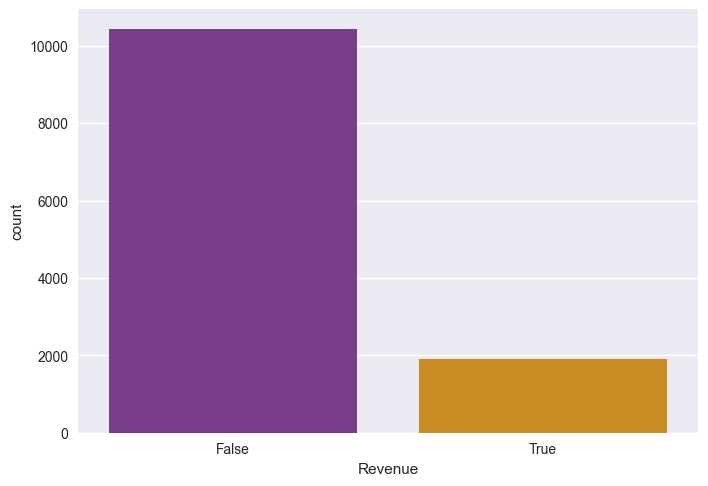

In [6]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Из графика отчётливо видно, что мы имеем дело с несбалансированной выборкой, так как соотношение классов — 85/15, что далеко от сбалансированного соотношения 50/50.

Из 12 330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Условимся, что лучшей будет считаться та модель, у которой значение метрики $F_1$ для пользователей, совершивших покупку, будет наибольшим.

Разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [7]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

Заранее определимся, как мы будем производить контроль качества наших моделей:
  * Разделим выборку на тренировочную и тестовую.
  * Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и 
    считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:
  * значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
  * значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

Для начала позаботимся о создании отложенной тестовой выборки. Разделим выборку на тренировочную и тестовую в соотношении 80/20. Используем разбиение, стратифицированное по целевому признаку.

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
# Выведем количество сессий, пришедшееся на каждую из выборок
print('Train:\n', X_train.shape[0], sep='')
print('Valid:\n', X_test.shape[0], sep='')

Train:
9864
Valid:
2466


Воспользуемся алгоритмом случайного леса (Random Forest) для решения данной задачи. Создадим модель, оставив все параметры по умолчанию. Оценим качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, воспользуемся кросс-валидатором StratifiedKFold. Для проведения кросс-валидации воспользуемся функцией cross_validate().

In [11]:
# Создаём объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
    random_state=42 # генератор случайных чисел
)

# Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

# Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=rf_clf, # модель
    X=X_train, # матрица наблюдений X
    y=y_train, # вектор ответов y
    cv=skf, # кросс-валидатор
    scoring='f1', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


Так как среднее значение $F_1$-score на треннировочных выборках имеет идеальное значение, а в валидационных фолдах значительно ниже, чем на тренировочных, можно с уверенностью сказать, что модель является переобученной.

Попробуем использовать несколько вариаций случайного леса и с помощью кривых обучения постараемся выбрать наилучшую из них.

Создадим список из трёх следующих моделей:
  * Случайный лес из деревьев максимальной глубины 5.
  * Случайный лес из деревьев максимальной глубины 7.
  * Случайный лес из деревьев максимальной глубины 12.

Для всех трёх моделей количество деревьев в лесу (n_estimators) возьмем равным 200, количество объектов в листе (min_samples_leaf) — 5. Параметр random_state = 42. Остальные параметры оставим по умолчанию.

Построим для каждой из моделей кривую обучения.

In [12]:
# Функция для отрисовки кривых обучения
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

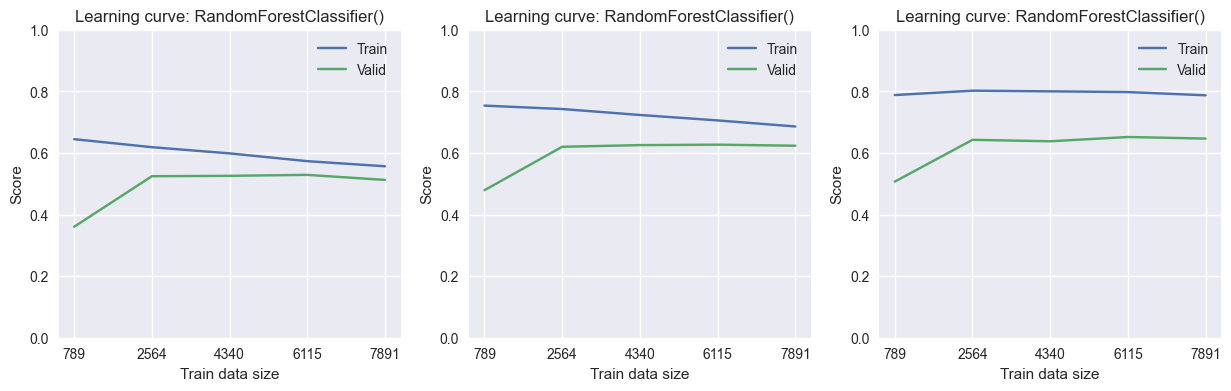

In [13]:
# Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев
        max_depth=5, # максимальная глубина
        min_samples_leaf=5, # количество объектов в листе
        random_state=42 # генератор случайных чисел
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев
        max_depth=7, # максимальная глубина
        min_samples_leaf=5, # количество объектов в листе
        random_state=42 # генератор случайных чисел
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев
        max_depth=12, # максимальная глубина
        min_samples_leaf=5, # количество объектов в листе
        random_state=42 # генератор случайных чисел
    ),
]

# Создаем объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
# Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) # фигура + 3 координатных плоскости
# Создаем цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): # i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X_train, y_train, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

Как видим, наиболее оптимальный вариант модкли имеет глубину деревьев 7. Теперь обучим случайный лес с оптимальной глубиной на тренировочной выборке. Сделаем предсказание меток классов и выведем отчёт о метриках классификации.

In [16]:
# Создаём объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
        n_estimators=200, # количество деревьев
        max_depth=7, # максимальная глубина
        min_samples_leaf=5, # количество объектов в листе
        random_state=42 # генератор случайных чисел
)
 
# Обучаем модель 
rf_clf.fit(X_train, y_train)

# Делаем предсказание класса
y_pred = rf_clf.predict(X_test)
# Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Попробуем повысить качество распознавания посетителей, совершивших покупку. Воспользуемся методом подбора порога вероятности с помощью PR-кривой. Порог вероятности будем подбирать с помощью кросс-валидации. Сделаем предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах.

Построим PR-кривую и отметим на ней точку, в которой наблюдается максимум метрики $F_1$ для посетителей, которые совершат покупку. Определим порог вероятности, соответствующий этой точке.

Best threshold = 0.36, F1-Score = 0.69


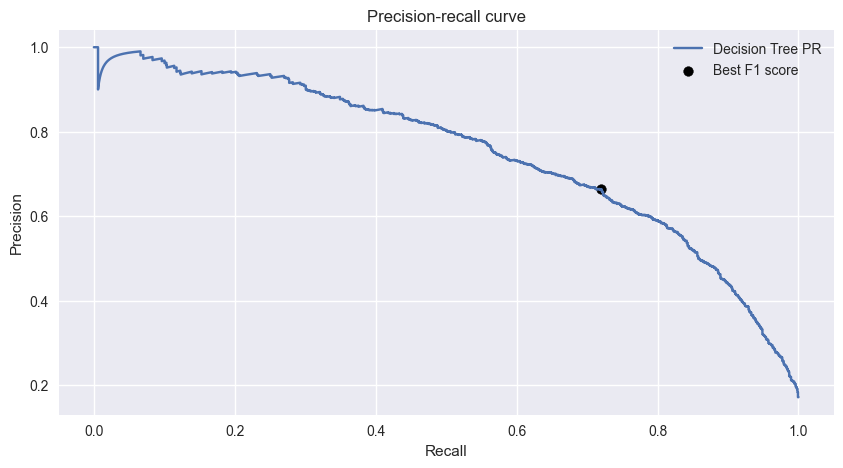

In [17]:
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(
    rf_clf, X_train, y_train, cv=skf, method='predict_proba'
)

# Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

# Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

# Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
# Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend();

Сделаем предсказание классов объекта с уже определённым порогом вероятности. Выведем отчёт о метриках классификации.

In [19]:
# Задаём оптимальный порог вероятностей
threshold_opt = 0.36

y_test_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')
# Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

